### **Bernstein–Vazirani Algorithm**

---

**1. Introduction**

**Input:** a function $f: \{0,1\}^n \to \{0,1\}$

<br>

**Promise:** there exists a binary string $$s = s_{n-1}s_{n-2}\dots s_1s_0$$
for which $$f(x) = s \cdot x \pmod 2$$

where the bitwise product is defined as:
$$s \cdot x = s_0 x_0 \oplus s_1 x_1 \oplus \dots \oplus s_{n-1} x_{n-1}$$

<br>

**Goal:** Recover the string $s$

<br>

---

<br>

**Quantum vs Classical**


 - Classical      =>      $n$ calls (one per bit of $s$)

<br>

 - Quantum         =>      1 single oracle call

---


In [68]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

n = 10
secret_string = "".join(np.random.choice(["0", "1"]) for _ in range(n))
print("Secret string : ", secret_string)

Secret string :  0111100111





**2. Building the BV Oracle**

The oracle must implement the transformation:

$$|x, y\rangle \to |x, \, y \oplus (s \cdot x)\rangle$$

For each bit in the secret string $s$:

* If $s[i] = 1$: Apply a CNOT gate using input qubit $i$ as control and the ancilla as target
* If $s[i] = 0$: Do nothing!

<br>

---


/Users/shyam/Documents/Quantum Projects/qiskit_venv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


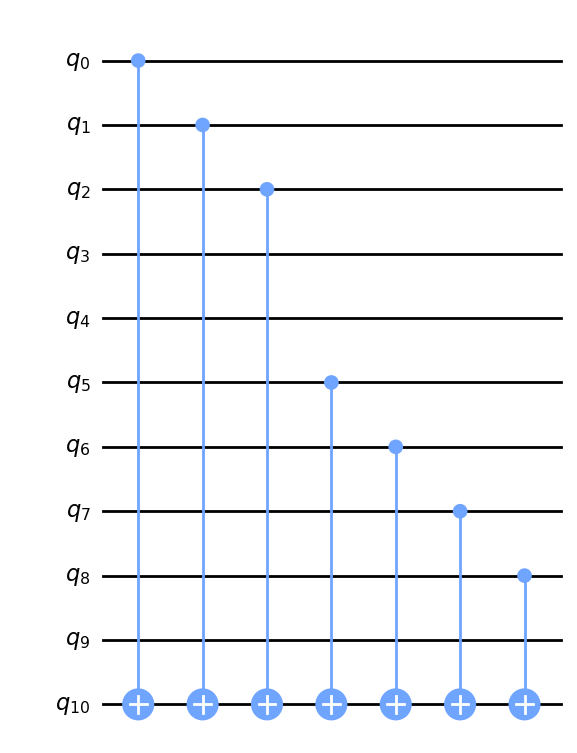

In [69]:

def build_bv_oracle(s):
    n = len(s)
    qc = QuantumCircuit(n + 1)

    for i, bit in enumerate(s[::-1]):
        if bit == "1":
            qc.cx(i, n)
    oracle = qc.to_gate()
    oracle.name="U_f"
    return oracle

bv_oracle = build_bv_oracle(secret_string)
bv_oracle.definition.draw('mpl')



<br>

**3. Constructing the BV Circuit**

The Bernstein–Vazirani algorithm follows these steps:


1.  **Initialization:** Start with data qubits in state $|0\rangle$ and the auxiliary qubit in state $|-\rangle$.

2.  **Superposition:** Apply **H gates** to all data qubits.

3.  **Oracle Query:** Apply the Oracle gate exactly once.

4.  **Apply H gates again** to all data qubits.

5.  **Measurement:** Measure the data qubits to reveal the secret string.

<br>

---


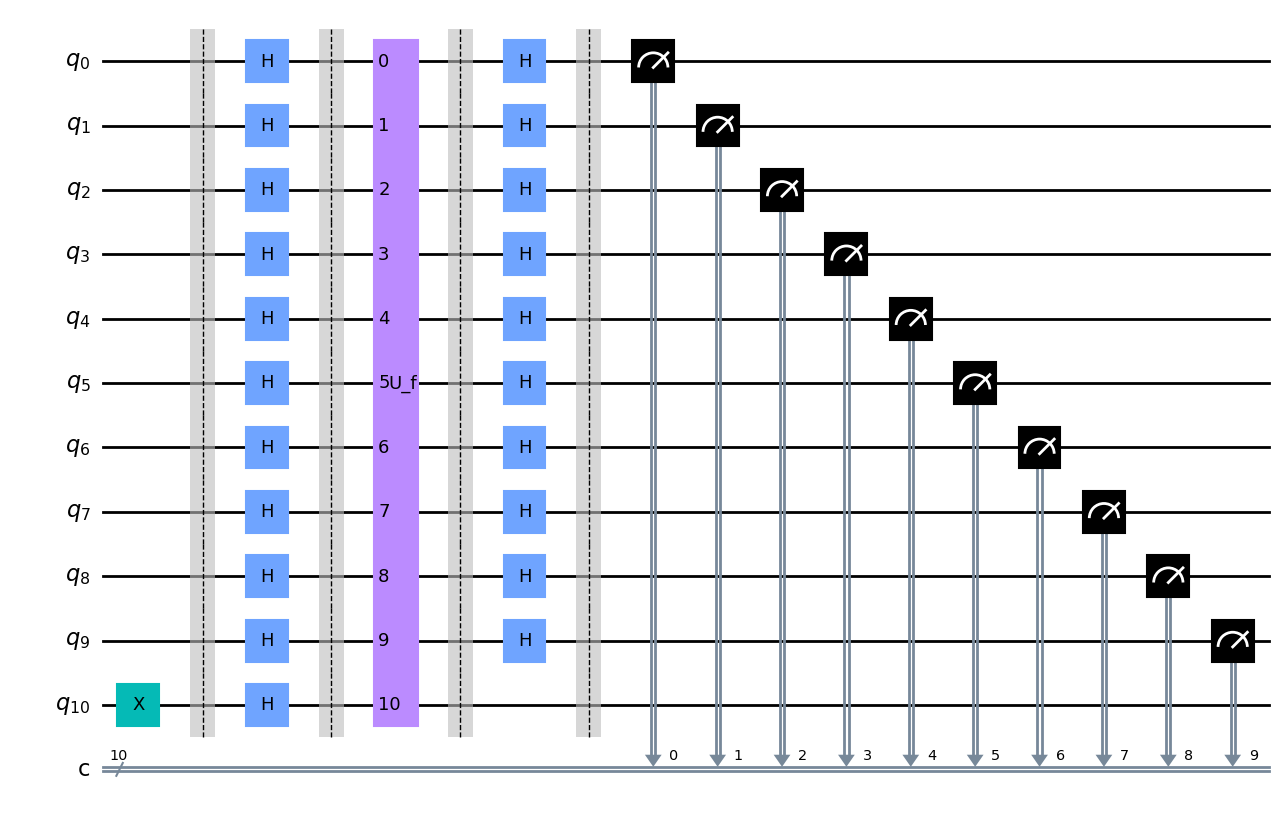

In [70]:
def bv_circuit(oracle, n):
    qc = QuantumCircuit(n + 1, n)

    # 1. Initialization
    qc.x(n)
    qc.barrier()

    # 2. Superposition
    qc.h(range(n + 1))
    qc.barrier()

    # 3. Oracle query
    qc.append(oracle, range(n+1))
    qc.barrier()

    # 4. Apply H again
    qc.h(range(n))
    qc.barrier()

    # 5. Measurement
    qc.measure(range(n), range(n))

    return qc

qc = bv_circuit(bv_oracle, n)
qc.draw("mpl")


**4. Simulation & Result Extraction**

Quantum computers output the secret string directly after one oracle call

<br>

---

Secret string:  0111100111
Measured string:  0111100111

Histogram:


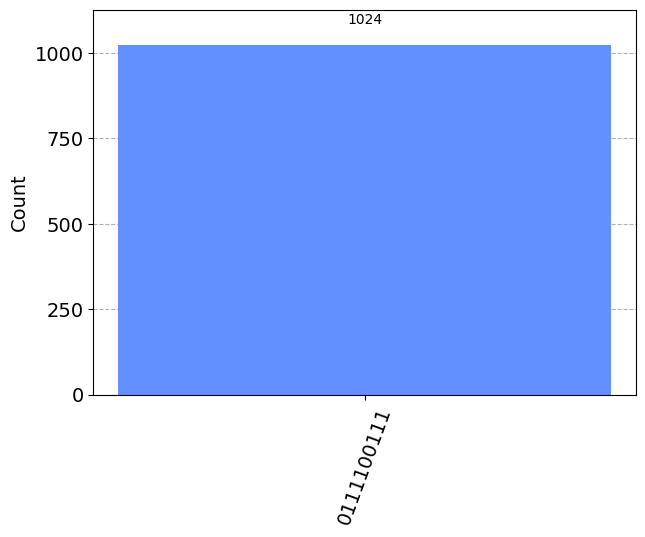

In [71]:

simulator = AerSimulator()

compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1024)

result = job.result()
counts = result.get_counts()

measured_string = list(counts.keys())[0]

print("Secret string: ", secret_string)
print("Measured string: ", measured_string)

print("\nHistogram:")
plot_histogram(counts)